## target
task : img classification

data : MNIST

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

In [2]:
# Hyper parameters
EPOCH = 10
BATCH_SIZE = 500
LR = 0.01
DOWNLOAD_MNIST = False # 請求下載

## train data

In [3]:
# download data
train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train=True, # is training data
    transform=torchvision.transforms.ToTensor(), # trans from numpy.ary to torch Tensor
    download = DOWNLOAD_MNIST,
)

torch.Size([60000, 28, 28])
torch.Size([60000])


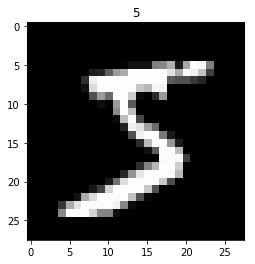

In [4]:
#plot one example
print(train_data.train_data.size())
print(train_data.train_labels.size())

plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [5]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# test data

In [6]:
test_data = torchvision.datasets.MNIST(root='./mnist', train=False)
len(test_data)

10000

In [7]:
test_x = Variable(torch.unsqueeze(test_data.test_data, dim=1), volatile=True).type(torch.FloatTensor)
test_x = test_x[:2000]/255.

test_y = test_data.test_labels[:2000]

## build CNN

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(# input size(1,28,28)
            nn.Conv2d( 
                in_channels = 1, # gray(if RGB, then in_channel=3)
                out_channels = 16, # num_filter
                kernel_size=5, # filter's height and width = 5
                stride=1, # shift 1 distance each time
                padding=2, # if stride=1, padding=(kernel_size-1)/2, filled with zero
            ),# -->(16, 28, 28)
            nn.ReLU(),# -->(16, 28, 28)
            nn.MaxPool2d(kernel_size=2,),# -->(16, 14, 14)
        )
        self.conv2 = nn.Sequential(# input size(16,14,14)
            nn.Conv2d(16, 32, 5, 1, 2), #(in, out, kernel, strid, padding) # -->(32, 14, 14)
            nn.ReLU(),# -->(32, 14, 14)
            nn.MaxPool2d(2), # -->(32, 7, 7)
        )
        self.out = nn.Linear(32*7*7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1) #(batch, 32*7*7)
        output = self.out(x)
        return output

In [9]:
cnn=CNN()
print(cnn)

CNN (
  (conv1): Sequential (
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (conv2): Sequential (
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU ()
    (2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (out): Linear (1568 -> 10)
)


##  training

In [10]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

In [11]:
FROBENIUS_NORM = 10. # gradient of loss t input
EARLYSTOPPING_N = 3

BREAK = False
earlystopping = 0
count = 0

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x, requires_grad=True) # batch x
        b_y = Variable(y) # batch y
        
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        test_output = cnn(test_x)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = sum(pred_y ==test_y)/ test_y.size(0)
        
        frobenius_norm =(b_x.grad**2).sum().sqrt()
        
        # print info each 100 iter
#         if count%100 ==0:
        print('Epoch ', epoch, ' | step ', step, 
              ' | train loss %.4f'%loss.data[0], 
              ' | test accuracy: %.4f'%accuracy,
              ' | gradient of loss to input ', frobenius_norm,
                 )
        print(frobenius_norm.data[0])
        
        if count > 100 :
            if frobenius_norm.data[0] > FROBENIUS_NORM :
                if earlystopping == EARLYSTOPPING_N :
                    FROBENIUS_NORM = frobenius_norm.data[0]
                    BREAK = True
                    break
                else:
                    earlystopping +=1
            else: # better frobenius_norm has been founded
                FROBENIUS_NORM = frobenius_norm.data[0]
                earlystopping = 0
        count +=1
    if BREAK: break

Epoch  0  | step  0  | train loss 2.3075  | test accuracy: 0.1095  | gradient of loss to input  Variable containing:
1.00000e-03 *
  4.7388
[torch.FloatTensor of size 1]

0.004738811869174242
Epoch  0  | step  1  | train loss 2.2777  | test accuracy: 0.4925  | gradient of loss to input  Variable containing:
1.00000e-03 *
  6.1318
[torch.FloatTensor of size 1]

0.006131846457719803
Epoch  0  | step  2  | train loss 2.1395  | test accuracy: 0.5785  | gradient of loss to input  Variable containing:
1.00000e-03 *
  5.2571
[torch.FloatTensor of size 1]

0.005257072392851114
Epoch  0  | step  3  | train loss 1.8971  | test accuracy: 0.6880  | gradient of loss to input  Variable containing:
1.00000e-03 *
  9.5607
[torch.FloatTensor of size 1]

0.009560720063745975
Epoch  0  | step  4  | train loss 1.4201  | test accuracy: 0.7370  | gradient of loss to input  Variable containing:
1.00000e-02 *
  1.5554
[torch.FloatTensor of size 1]

0.01555376686155796
Epoch  0  | step  5  | train loss 0.9502 

Epoch  0  | step  43  | train loss 0.1887  | test accuracy: 0.9480  | gradient of loss to input  Variable containing:
1.00000e-02 *
  4.3532
[torch.FloatTensor of size 1]

0.04353165253996849
Epoch  0  | step  44  | train loss 0.1408  | test accuracy: 0.9505  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.4412
[torch.FloatTensor of size 1]

0.034412235021591187
Epoch  0  | step  45  | train loss 0.1114  | test accuracy: 0.9490  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.1123
[torch.FloatTensor of size 1]

0.031122641637921333
Epoch  0  | step  46  | train loss 0.1313  | test accuracy: 0.9500  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.7955
[torch.FloatTensor of size 1]

0.03795517981052399
Epoch  0  | step  47  | train loss 0.1306  | test accuracy: 0.9530  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.4867
[torch.FloatTensor of size 1]

0.03486652672290802
Epoch  0  | step  48  | train loss 0.1

Epoch  0  | step  86  | train loss 0.0910  | test accuracy: 0.9695  | gradient of loss to input  Variable containing:
1.00000e-02 *
  4.2699
[torch.FloatTensor of size 1]

0.042699091136455536
Epoch  0  | step  87  | train loss 0.0968  | test accuracy: 0.9720  | gradient of loss to input  Variable containing:
1.00000e-02 *
  4.1034
[torch.FloatTensor of size 1]

0.0410340242087841
Epoch  0  | step  88  | train loss 0.0851  | test accuracy: 0.9700  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.7248
[torch.FloatTensor of size 1]

0.03724842518568039
Epoch  0  | step  89  | train loss 0.0585  | test accuracy: 0.9700  | gradient of loss to input  Variable containing:
1.00000e-02 *
  3.5256
[torch.FloatTensor of size 1]

0.03525581210851669
Epoch  0  | step  90  | train loss 0.0724  | test accuracy: 0.9725  | gradient of loss to input  Variable containing:
1.00000e-02 *
  4.0785
[torch.FloatTensor of size 1]

0.04078534618020058
Epoch  0  | step  91  | train loss 0.078

In [12]:
### train
# train_loss
loss.data[0]
# train_acc
train_x = Variable(torch.unsqueeze(train_data.train_data, dim=1), volatile=True).type(torch.FloatTensor)/255.
train_prediction = cnn.forward(train_x)
train_pred = torch.max(train_prediction, 1)[1].data.squeeze()
train_y = train_data.train_labels
train_acc = sum(train_pred ==train_y)/ train_y.size(0)

### test
test_pred = cnn.forward(test_x)

# test_loss
test_loss = loss_func(test_pred, Variable(test_y))
# test_acc
test_pred = torch.max(test_pred, 1)[1].data.squeeze()
test_acc = sum(test_pred ==test_y)/ test_y.size(0)

In [13]:
print('Batch size : %s \n' % str(BATCH_SIZE))

# frobenius_norm
print('FROBENIUS_NORM %.4f' % FROBENIUS_NORM)

# training data
print('train_loss %.4f' % loss.data[0]) # training loss
print('train_acc %.4f' % train_acc)
print('test_loss %.4f' % test_loss.data[0])
print('test_acc %.4f' % test_acc)

Batch size : 500 

FROBENIUS_NORM 0.0514
train_loss 0.1101
train_acc 0.9789
test_loss 0.0766
test_acc 0.9750


In [14]:
# Batch size : 6000 

# FROBENIUS_NORM 0.0094
# train_loss 0.0562
# train_acc 0.9836
# test_loss 0.0619
# test_acc 0.9790



# Batch size : 6000 

# FROBENIUS_NORM 0.0103
# train_loss 0.0672
# train_acc 0.9791
# test_loss 0.0841
# test_acc 0.9760



# Batch size : 6000 

# FROBENIUS_NORM 0.0110
# train_loss 0.0631
# train_acc 0.9850
# test_loss 0.0553
# test_acc 0.9800


In [15]:
# Batch size : 1000 

# FROBENIUS_NORM 0.0328
# train_loss 0.0612
# train_acc 0.9809
# test_loss 0.0739
# test_acc 0.9770



# Batch size : 1000 

# FROBENIUS_NORM 0.0243
# train_loss 0.0370
# train_acc 0.9871
# test_loss 0.0504
# test_acc 0.9845


# Batch size : 1000 

# FROBENIUS_NORM 0.0241
# train_loss 0.0418
# train_acc 0.9876
# test_loss 0.0567
# test_acc 0.9815

In [ ]:
# Batch size : 500 

# FROBENIUS_NORM 0.0514
# train_loss 0.1101
# train_acc 0.9789
# test_loss 0.0766
# test_acc 0.9750


In [16]:
# Batch size : 100 

# FROBENIUS_NORM 0.1082
# train_loss 0.1133
# train_acc 0.9731
# test_loss 0.0930
# test_acc 0.9715

# Batch size : 100 

# FROBENIUS_NORM 0.0442
# train_loss 0.0346
# train_acc 0.9761
# test_loss 0.0883
# test_acc 0.9700

# Batch size : 100 

# FROBENIUS_NORM 0.1303
# train_loss 0.1234
# train_acc 0.9683
# test_loss 0.1253
# test_acc 0.9590


In [17]:
# Batch size : 50 

# FROBENIUS_NORM 0.1729
# train_loss 0.2023
# train_acc 0.9558
# test_loss 0.1717
# test_acc 0.9490



# Batch size : 50 

# FROBENIUS_NORM 0.0979
# train_loss 0.0539
# train_acc 0.9602
# test_loss 0.1804
# test_acc 0.9460



# Batch size : 50 

# FROBENIUS_NORM 0.2231
# train_loss 0.2181
# train_acc 0.9336
# test_loss 0.2468
# test_acc 0.9200

In [18]:
# Batch size : 10 

# FROBENIUS_NORM 0.9122
# train_loss 0.1146
# train_acc 0.9687
# test_loss 0.1480
# test_acc 0.9490



# Batch size : 10 

# FROBENIUS_NORM 0.9778
# train_loss 0.1381
# train_acc 0.9492
# test_loss 0.2104
# test_acc 0.9355



# Batch size : 10 

# FROBENIUS_NORM 1.4456
# train_loss 0.2361
# train_acc 0.9508
# test_loss 0.2194
# test_acc 0.9365